<div class="alert alert-block alert-info"><b></b>
<h1><center> <font color='black'> Homework 06  </font></center></h1>
<h2><center> <font color='black'> Knowledge graphs &  Fairness and Explainability </font></center></h2>
<h2><center> <font color='black'> Due date : 24 May 23:59 </font></center></h2>    
<h2><center> <font color='black'> BDA - University of Tartu - Spring 2020</font></center></h3>
</div>

# Homework Instructions

- Insert your team member names and student IDs in the field "Team mates" below. If you are not working in a team please insert only your name, surname and student ID 

- The accepted submission formats are Colab links or .ipynb files. If you are submitting Colab links please make sure that the privacy settings for the file is public so we can access your code. 

- The submission will automatically close at 12:00 am, so please make sure you have enough time to submit the homework. 

- Only one of the teammates should submit the homework. We will grade and give points to both of you! 

- You do not necessarily need to work on Colab. Especially as the size and the complexity of datasets will increase through the course, you can install jupyter notebooks locally and work from there.

- If you do not understand what a question is asking for, please ask in Moodle. 

**<h2><font color='red'>Team mates:</font></h2>**


<font color='red'>Name Surname: XXXXX</font>&emsp;   <font color='red'>Student ID: YYYY</font>


<font color='red'>Name Surname: XXXXX</font>&emsp;   <font color='red'>Student ID: YYYY</font>

# 1. Knowledge graphs (7 points)

## 1.1 Insurance fraud (2.5 points)

In this exercise you will try to depict car insurance fraudsters using knowledge graphs. Firstly, go through this [page](http://www.ibc.ca/on/auto/insurance-crime/staged-collisions) to learn more about the staged collisions. You can use additional sources if you want to get a more detailed information.

Load the datasets people.csv and accidents.csv. This is synthetic data and none of the records are related to actual events or people. The file people.csv contains information about 8 people who involved in four different accidents. The file accidents.csv contains data related to this four accidents.
The fields included are:

**Accident_ID:** Self-descriptive

**Location:** The location where the accident happened

**CarID_1:** The ID of the first car involved in the accident

**CarID_2:** The ID of the second car involved in the accident

**DriverID_1:** The ID of the user who was driving the car in CarID_1

**DriverID_2:** The ID of the user who was driving the car in CarID_2

**Take a look at the data in both dataframes. At least 3 out of 8 people are suspected to be fraudsters. Can you tell just by looking at the dataframes who might they be ?** (This is just a warm up for the exercise. No grades will be given for your answer. However we would be really interested to know if somebody has excellent observation skills)

In [124]:
%%capture
# !pip install ampligraph

import numpy as np
import pandas as pd
import ampligraph

import re
import bs4
import requests
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()
# nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

ampligraph.__version__

In [1]:
import pandas as pd

people = pd.read_csv('people.csv')
accidents = pd.read_csv('accidents.csv')

print(people)
print(accidents)

   User_ID First Name Last Name  Age           Address  Accident_ID     ROLE
0        1    Chester    Murphy   25  Narva 108, Tartu            1   Driver
1        2     Walter    Turner   26   Tilgi 49, Tartu            2   Driver
2        3      Daryl    Fowler   25    Piik 67, Tartu            1   Driver
3        4        Ted    Nelson   45   Herne 20, Tartu            3   Driver
4        5     Olivia  Crawford   38  Kalevi 25, Tartu            2   Driver
5        1    Chester    Murphy   25  Narva 108, Tartu            2  Witness
6        6        Amy    Miller   27   Riia 408, Tartu            3   Driver
7        7        Tes     Smith   25  Narva 108, Tartu            4   Driver
8        8       Josh     Blake   36  Parnu 37, Tallin            4   Driver
9        3      Daryl    Fowler   25    Piik 67, Tartu            4  Witness
   Accident_ID Location  CarID_1  CarID_2  DriverID_1  DriverID_2
0            1    Tartu     1000     1001           1           3
1            2   Tall

<font color='red'> **Answer:** </font>
    
3 suscpected people as fraudsters:
- user_id 1
- user_id 3
- user_id 2

**1.1.1 Knowledge graphs might help to recognize the fraudsters. In order to build knowledge graphs you have first to build the triples: source --> target --> edge. Store these triples in a new dataframe. The dataframe should cover all the relations in the table below:  (1.5 points)**

|      Source      |    Target   |     Edge    |
|:----------------:|:-----------:|:-----------:|
| User_ID(or Name) |    Car_ID   |    Drives   |
| User_ID(or Name) | Accident_ID |   Witness   |
|      Car_ID      | Accident_ID | Involved in |
|    Accident_ID   |   Location  | Happened in |
| User_ID(or Name) | Address     | Lives in    |

In [3]:
# people
df1 = people.drop(columns=['Age', 'First Name', 'Last Name'])
df1['User_ID_Name'] = people['User_ID'].astype(str) + "_" + people['First Name'] + people['Last Name']
df1 = df1.reindex(columns=['User_ID', 'User_ID_Name', 'Address', 'Accident_ID', 'ROLE'])
df1

,User_ID,User_ID_Name,Address,Accident_ID,ROLE
0,1,1_ChesterMurphy,"Narva 108, Tartu",1,Driver
1,2,2_WalterTurner,"Tilgi 49, Tartu",2,Driver
2,3,3_DarylFowler,"Piik 67, Tartu",1,Driver
3,4,4_TedNelson,"Herne 20, Tartu",3,Driver
4,5,5_OliviaCrawford,"Kalevi 25, Tartu",2,Driver
5,1,1_ChesterMurphy,"Narva 108, Tartu",2,Witness
6,6,6_AmyMiller,"Riia 408, Tartu",3,Driver
7,7,7_TesSmith,"Narva 108, Tartu",4,Driver
8,8,8_JoshBlake,"Parnu 37, Tallin",4,Driver
9,3,3_DarylFowler,"Piik 67, Tartu",4,Witness


In [4]:
df2 = accidents
df2

,Accident_ID,Location,CarID_1,CarID_2,DriverID_1,DriverID_2
0,1,Tartu,1000,1001,1,3
1,2,Tallin,1002,1003,2,5
2,3,Tartu,1004,1005,4,6
3,4,Tallin,1006,1007,7,8


In [5]:
# row1
triples = [('1_ChesterMurphy', '1000', 'Drives'),
            ('2_WalterTurner', '1001', 'Drives'),
            ('3_DarylFowler', '1002', 'Drives'),
            ('4_TedNelson', '1003', 'Drives'),
            ('5_OliviaCrawford', '1004', 'Drives'),
            ('6_AmyMiller', '1005', 'Drives'),
            ('7_TesSmith', '1006', 'Drives'),
            ('8_JoshBlake', '1007', 'Drives'),
          ]

In [6]:
# row2
triples.extend([('1_ChesterMurphy', '1', 'Witness'), 
                ('3_DarylFowler', '1', 'Witness')])

In [7]:
# row3
triples.extend([('1000', '1', 'Involved in'), 
                ('1001', '1', 'Involved in'), 
                ('1002', '2', 'Involved in'), 
                ('1003', '2', 'Involved in'), 
                ('1004', '3', 'Involved in'), 
                ('1005', '3', 'Involved in'), 
                ('1006', '4', 'Involved in'), 
                ('1007', '4', 'Involved in')])

In [8]:
# row4
triples.extend([('1', 'Tartu', 'Happened In'),
                ('2', 'Tallin', 'Happened In'),
                ('3', 'Tartu', 'Happened In'),
                ('4', 'Tallin', 'Happened In')])

In [9]:
# row5
triples.extend([('1_ChesterMurphy', 'Narva 108, Tartu', 'Lives In'),
                ('2_WalterTurner', 'Tilgi 49, Tartu', 'Lives In'),
                ('3_DarylFowler', 'Piik 67, Tartu', 'Lives In'),
                ('4_TedNelson', 'Herne 20, Tartu', 'Lives In'),
                ('5_OliviaCrawford', 'Kalevi 25, Tartu', 'Lives In'),
                ('6_AmyMiller', 'Riia 408, Tartu', 'Lives In'),
                ('7_TesSmith', 'Narva 108, Tartu', 'Lives In'),
                ('8_JoshBlake', 'Parnu 37, Tallin', 'Lives In')])

In [10]:
triples_df = pd.DataFrame(triples, columns=["source", "target", "edge"])
triples_df

,source,target,edge
0,1_ChesterMurphy,1000,Drives
1,2_WalterTurner,1001,Drives
2,3_DarylFowler,1002,Drives
3,4_TedNelson,1003,Drives
4,5_OliviaCrawford,1004,Drives
5,6_AmyMiller,1005,Drives
6,7_TesSmith,1006,Drives
7,8_JoshBlake,1007,Drives
8,1_ChesterMurphy,1,Witness
9,3_DarylFowler,1,Witness


**1.1.2 Use the dataframe which contains your triples to build a knowledge graph. You can use a paper drawing or any other drawing software. Hint: Try to keep an hierarchy while you draw i.e the accidents at the top at same level, the cars one level below etc. By doing so your graph will be more clear and you can easily get some clues. Insert the picture of your graph in the cell below.** <font color='red'> **Do not forget to send it in your submission as well** **(0.5 points)**

In [11]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(triples_df, "source", "edge", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'nx' is not defined

**1.1.3 Mention at least the names of 3 people that you think are commiting insurance fraud by looking at the knowledge graph. Describe the factors why did you choose those 3. The description should include at least 3 key points. Please elaborate as much as possible. (0.5 points)**

<font color='red'> **Answer:** </font>

//TODO


## 1.2 Knowledge graph for clustering and classification (4.5 points)

In this exercise you are going to use the dataset from [kaggle](https://www.kaggle.com/jaykay12/odi-cricket-matches-19712017#ContinousDataset.csv) that contains all the ODI Cricket Matches in the interval 1971-2017. Cricket is a popular game  played in South Asian countries and Australia,
which was originally introduced by British colonization. If you would like more information, [Lagaan](https://www.youtube.com/watch?v=oSIGQ0YkFxs) is an intersting Oscar candidate movie that explains the relation between colonial taxes and popularity of cricket.

In this dataset the field "Ground" refers to the location where the match was held. 

**1.2.1 Load the dataset cricket_data.csv. Create the entities match_id, ground_id,country_id,home_team_id,away_team_id and neutral that are going to be part of our knowledge graph. (0.5 points)**

In [66]:
df = pd.read_csv('cricket_data.csv')
df.head()

,ground,date,winner,host_country,home_team,away_team,neutral
0,Melbourne,"Jan 5, 1971",Australia,Australia,Australia,England,False
1,Manchester,"Aug 24, 1972",England,England,England,Australia,False
2,Lord's,"Aug 26, 1972",Australia,England,England,Australia,False
3,Birmingham,"Aug 28, 1972",England,England,England,Australia,False
4,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,New Zealand,Pakistan,False


In [67]:
df.isna().sum()

ground          0
date            0
winner          0
host_country    0
home_team       0
away_team       0
neutral         0
dtype: int64

In [68]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["ground_id"] = "Ground" + df.ground.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.host_country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

In [69]:
df.head()

,ground,date,winner,host_country,home_team,away_team,neutral,match_id,ground_id,country_id,home_team_id,away_team_id
0,Melbourne,"Jan 5, 1971",Australia,Australia,Australia,England,False,Match0,GroundMelbourne,CountryAustralia,TeamAustralia,TeamEngland
1,Manchester,"Aug 24, 1972",England,England,England,Australia,False,Match1,GroundManchester,CountryEngland,TeamEngland,TeamAustralia
2,Lord's,"Aug 26, 1972",Australia,England,England,Australia,False,Match2,GroundLord'S,CountryEngland,TeamEngland,TeamAustralia
3,Birmingham,"Aug 28, 1972",England,England,England,Australia,False,Match3,GroundBirmingham,CountryEngland,TeamEngland,TeamAustralia
4,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,New Zealand,Pakistan,False,Match4,GroundChristchurch,CountryNewZealand,TeamNewZealand,TeamPakistan


**1.2.2 Select manually 80%  as train set of the data and create the triples ['subject', 'predicate', 'object'] using the entities from 1.2.1. (1 points)** Hint: If there are some errors generated while building the triples check if match_id was formed correctly in 1.2.1

In [70]:
num_train = int(np.round(0.8 * len(df), 0)) # 80% of dataset
num_train

5891

In [81]:
df["train"] = df.index < num_train

In [84]:
df["train"].value_counts()

True     5891
False    1473
Name: train, dtype: int64

In [88]:
triples = []
for _, row in df[df["train"]].iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    # Match results
    if row["winner"] == row["home_team"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["away_team_id"], "winnerOf", row["match_id"])
        score_away = (row["home_team_id"], "loserOf", row["match_id"])
    
    # Match characteristics
    ground = (row["match_id"], "inGround", row["ground_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][-4:])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    ground, country, neutral, year))

In [89]:
type(triples)

list

In [91]:
triples

[('TeamAustralia', 'isHomeTeamIn', 'Match0'),
 ('TeamEngland', 'isAwayTeamIn', 'Match0'),
 ('TeamAustralia', 'winnerOf', 'Match0'),
 ('TeamEngland', 'loserOf', 'Match0'),
 ('Match0', 'inGround', 'GroundMelbourne'),
 ('Match0', 'inCountry', 'CountryAustralia'),
 ('Match0', 'isNeutral', 'False'),
 ('Match0', 'atYear', '1971'),
 ('TeamEngland', 'isHomeTeamIn', 'Match1'),
 ('TeamAustralia', 'isAwayTeamIn', 'Match1'),
 ('TeamEngland', 'winnerOf', 'Match1'),
 ('TeamAustralia', 'loserOf', 'Match1'),
 ('Match1', 'inGround', 'GroundManchester'),
 ('Match1', 'inCountry', 'CountryEngland'),
 ('Match1', 'isNeutral', 'False'),
 ('Match1', 'atYear', '1972'),
 ('TeamEngland', 'isHomeTeamIn', 'Match2'),
 ('TeamAustralia', 'isAwayTeamIn', 'Match2'),
 ('TeamAustralia', 'winnerOf', 'Match2'),
 ('TeamEngland', 'loserOf', 'Match2'),
 ('Match2', 'inGround', "GroundLord'S"),
 ('Match2', 'inCountry', 'CountryEngland'),
 ('Match2', 'isNeutral', 'False'),
 ('Match2', 'atYear', '1972'),
 ('TeamEngland', 'isHomeT

In [94]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.head()

,subject,predicate,object
0,TeamAustralia,isHomeTeamIn,Match0
1,TeamEngland,isAwayTeamIn,Match0
2,TeamAustralia,winnerOf,Match0
3,TeamEngland,loserOf,Match0
4,Match0,inGround,GroundMelbourne


**1.2.3 Select only one match_id and visualize its knowledge graph using networkx (0.25 points)**

In [98]:
triples_df[(triples_df.subject=="Match555") | (triples_df.object=="Match555")]

,subject,predicate,object
4440,TeamIndia,isHomeTeamIn,Match555
4441,TeamSriLanka,isAwayTeamIn,Match555
4442,TeamIndia,winnerOf,Match555
4443,TeamSriLanka,loserOf,Match555
4444,Match555,inGround,GroundAhmedabad
4445,Match555,inCountry,CountryIndia
4446,Match555,isNeutral,False
4447,Match555,atYear,1989


In [104]:
import networkx as nx
import matplotlib.pyplot as plt

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(triples_df, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

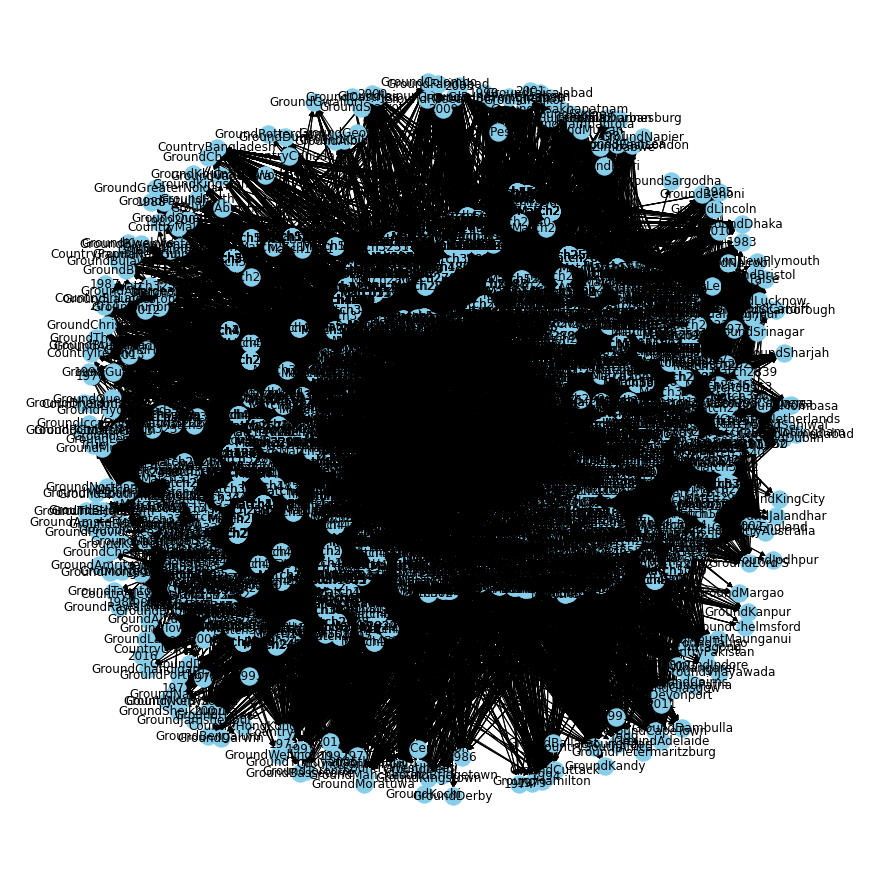

In [105]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

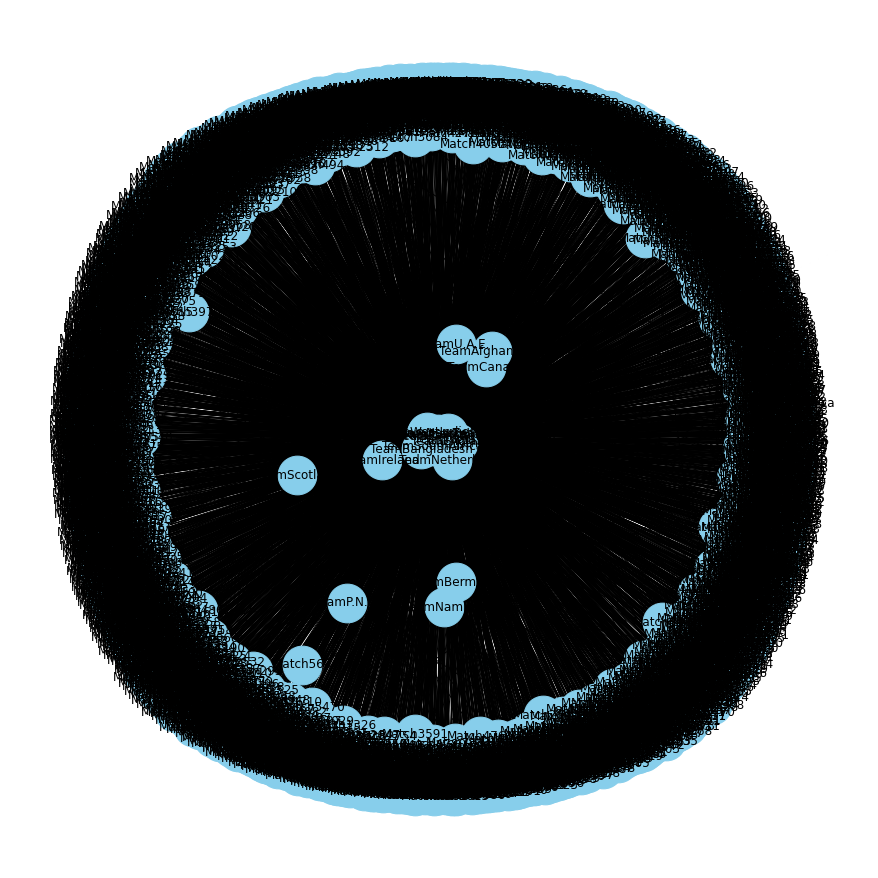

In [106]:
G=nx.from_pandas_edgelist(triples_df[triples_df['predicate']=="isHomeTeamIn"], "subject", "object",  
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

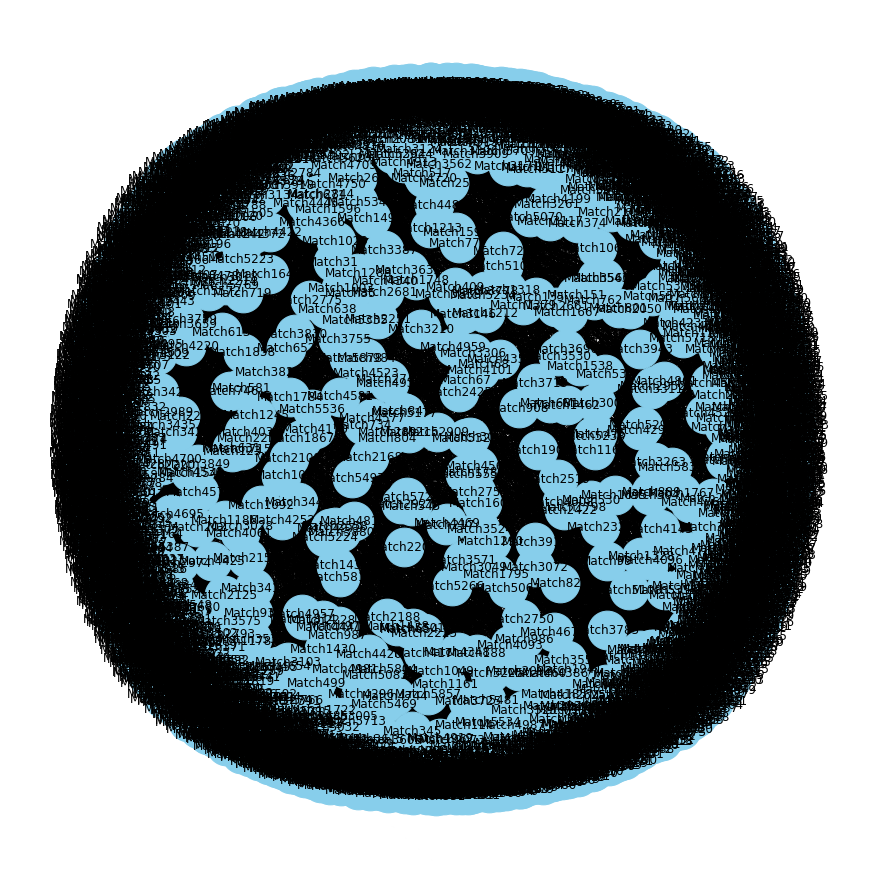

In [107]:
G=nx.from_pandas_edgelist(triples_df[triples_df['predicate']=="atYear"], "subject", "object",  
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

**1.2.4 Split the triples into train and validation set. Set the test size equal to 20% of the records in the dataset. Train the ComplexEx model for knowledge graphs embeddings and evaluate its performance using mr_score, mrr_score, hits_at_n_score. (0.75 points)**

In [121]:
from ampligraph.evaluation import train_test_split_no_unseen

test_size = int(len(triples) * 0.2)
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=test_size)

In [122]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (37703, 3)
Test set size:  (9425, 3)


In [130]:
!pip install tensorflow

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [131]:
from ampligraph.latent_features import ComplEx
import tensorflow as tf

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

AttributeError: module 'tensorflow.python.framework.op_def_registry' has no attribute 'register_op_list'

In [129]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

AttributeError: module 'tensorflow' has no attribute 'logging'

In [ ]:
filter_triples = np.concatenate((X_train, X_valid))

In [132]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

NameError: name 'model' is not defined

In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

**1.2.5 Create a dictionary with the embeddings of all teams and use PCA to project embeddings to 2D space. Cluster the team embeddings in 6 clusters and plot them in a 2D graph. (0.75 points)**

In [ ]:
%%capture
# !pip install seaborn adjustText
# !git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
# !pip install incf.countryutils/.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [ ]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

In [ ]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='entity')

In [ ]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

In [ ]:
plot_df = pd.DataFrame({"teams": teams, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [ ]:
## change the top20 team //TODO
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland", "TeamPortugal", "TeamCroatia", "TeamSpain", 
              "TeamUruguay", "TeamSwitzerland", "TeamDenmark", "TeamArgentina", "TeamGermany", "TeamColombia",
              "TeamItaly", "TeamNetherlands", "TeamChile", "TeamSweden", "TeamMexico", "TeamPoland", "TeamIran"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

In [ ]:
plot_clusters("continent")

In [ ]:
plot_clusters("cluster")

**1.2.6 In order to predict if the home team is going to win or lose we need to define a target variable. Create a new column called "result" in the dataframe that takes the value 'home_team_wins' if the home team is the winner and 'home_team_loses' if the home team has not won the match. (0.25 points)**

In [ ]:
df["results"] = (df.home_score > df.away_score).astype(int) + \
                (df.home_score == df.away_score).astype(int)*2 + \
                (df.home_score < df.away_score).astype(int)*3 - 1

In [ ]:
df.results.value_counts(normalize=True)

**1.2.7 Create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset (You can use the function from practice session). Run the function to get the variables for X_train, y_train, X_test and y_test. Remember that the train set indices are the same as in 1.2.2 (0.5 points)**


In [ ]:
def get_features_target(mask):
    
    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, np.nan))
    
    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [ ]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [ ]:
clf_X_train.shape, clf_X_test.shape

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

**1.2.8 Create an instance of XGBClassifier and fit the training samples. Evaluate the accuracy of the model in test set. (0.5 points)**

In [ ]:
#%%capture
#!pip install xgboost
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
clf_model.fit(clf_X_train, y_train)

In [ ]:
df[~df["train"]].results.value_counts(normalize=True)

In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

# 2. Fairness & Interpretability ( 5 points)

In this section you are going to use the standard German Credit dataset used to bechmark many model interpretability techniques. The daset contains 1000 records of loan applications associatid with a risk score: Good or Bad.

**2.1 Load the dataset german_credit_data.csv. The dataset has some empty values. Choose one imputation method for each columnd and fill in the empty cells. (0.5 points)**

In [134]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
Using TensorFlow backend.


In [135]:
gcd = pd.read_csv("german_credit_data.csv")
gcd.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [140]:
## TODO - Imputation for some empty values 


**2.2 Plot the values of the column Age against the Risk column. Do you think there exist  bias in this dataset ? (0.5 points)**

<font color='red'> **Answer:**


**2.3 Calculate the percentage of the applications by gender Female that got a Bad credit score and a Good credit score. Do the same for Male gender. Do you believe there is enough data to think there is a bias in the dataset ? (0.5 points)**

<font color='red'> **Answer:**


**2.4 Copy the data in a new dataframe and perform label encoding. Split the dataset in 80% train and 70% test set while keeping the random state equal to 99. Train the XGBoost classifier below and predict the results in test set. Report the accuracy and F1-score. Plot the classifcation report as well. (0.5 points)**

In [141]:
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=99)

In [142]:
xgc.fit(X_train, y_train)

NameError: name 'y_train' is not defined

In [ ]:
predictions = xgc.predict(X_test)
predictions[:10]

In [ ]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

**2.5 Plot 3 types of  feature importance given by XGBoost and interpret the results. (0.5 points)**

In [ ]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

<font color='red'> **Answer:**


**2.6 Use eli5 to analyze the most important features of a sample where the credit score is equal to Bad and another sample when the credit score is equal to Good. Explain briefly the results (0.5 points)**

In [ ]:
eli5.show_weights(xgc.get_booster())

In [ ]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns) ,show_feature_values=True)

<font color='red'> **Answer:**


**2.7 Use SHAP to explain the prediction of the model for a sample where the credit score is equal to Bad and another sample when the credit score is equal to Good. Explain briefly the results.(0.5 points)**

In [ ]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [ ]:
pd.DataFrame(shap_values).head()

In [ ]:
print('Expected Value:', explainer.expected_value)

<font color='red'> **Answer:**


**2.8 Use SHAP to explain the prediction of the model for  the first 250 samples. Based on the similar patterns explain briefly the results(0.75 points)**

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_disp.iloc[:1000,:])

<font color='red'> **Answer:**


**2.9 Plot as a bar chart the feature importances received from SHAP. Finally compare these results  with the result from 2.5 and 2.8. (0.75 points)**

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

<font color='red'> **Answer:**


## How long did it take you to solve the homework?

* Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay, if it took 0.5 hours or 24 hours. The collected information will be used to improve future homeworks.

<font color='red'> **Answer:**</font>

**<font color='red'>(please change X in the next cell into your estimate)</font>**

X hours

## What is the level of difficulty for this homework?
you can put only number between $0:10$ ($0:$ easy, $10:$ difficult)

<font color='red'> **Answer:**</font>